In [79]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
sys.path.append('../../../spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow


In [80]:
# %%time
files = sorted(glob('spicy_s1_stacks/*.nc'))

# Create parameter space
A = 2.5
B = 0.2
C = 0.55

wet_snow_thresh = np.arange(4, -4, -0.1)
#wet_snow_thresh = np.arange(-4, -1, 1)

for f in files:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    print(datetime.now(), f' -- starting {ds_name}')
    # Open dataset 
    ds_ = xr.open_dataset(f).load()
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]
    # Initialize RMSE arrays
    rmse_wet_flag = xr.DataArray(np.empty(len(wet_snow_thresh))*np.nan,
                        coords={'wet_snow_thresh':wet_snow_thresh}, dims=('wet_snow_thresh'))
    rmse_no_flag = xr.DataArray(np.empty(len(wet_snow_thresh))*np.nan,
                        coords={'wet_snow_thresh':wet_snow_thresh}, dims=('wet_snow_thresh'))
    
    # Brute-force loop

    for wst in wet_snow_thresh:
        print(f'A={A}; B={B}; C={C}; wst={wst}')
        ds = calc_delta_cross_ratio(dataset, A=A, inplace=False)
        ds = calc_delta_gamma(ds, B=B, inplace=False)
        
        ds = clip_delta_gamma_outlier(ds)
        ds = calc_snow_index(ds)
        ds = calc_snow_index_to_snow_depth(ds, C=C, inplace=False)
        ds = id_newly_wet_snow(ds,wet_thresh=wst)
        ds = id_wet_negative_si(ds)
        ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
        ds = flag_wet_snow(ds)
        # Compare snow depths - mask wet snow
        mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
                ds['wet_snow'].sel(time=closest_ts).astype(bool))
        diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
        rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
        print(f'RMSE wet = {rmse_wet}')
        rmse_wet_flag.loc[wst] = rmse_wet
        # Compare snow depths - no wet snow mask
        mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
        diff = ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)
        rmse = float(np.sqrt((diff**2).sum()/len(diff.values.flatten())))
        print(f'RMSE = {rmse}')
        rmse_no_flag.loc[wst] = rmse

    # After loop, save RMSE results per file
    rmse_wet_flag.to_netcdf(f'rmse_out/{ds_name}_wet_flag.nc')
    rmse_no_flag.to_netcdf(f'rmse_out/{ds_name}_no_flag.nc')
    

2023-06-12 15:46:21.670150  -- starting Banner_2020-02-18
A=2.5; B=0.2; C=0.55; wst=4.0


KeyboardInterrupt: 

In [ ]:
results = sorted(glob('rmse_out/*.nc'))
names = []
for f in results:
    if 'no_flag' in f:
        continue
    ds_name = f.split('rmse_out/')[-1]
    ds_name = ds_name.split('_wet')[0]
    names.append(ds_name)
thresh_results = pd.DataFrame(columns=names)

for f in results:
    if 'no_flag' in f:
        continue
    r = xr.open_dataarray(f).load()
    ds_name = f.split('rmse_out/')[-1]
    ds_name = ds_name.split('_wet')[0]
    for ind,val in zip(r.wet_snow_thresh.values,r.values):
        thresh_results.loc[ind,ds_name] = val

<Axes: >

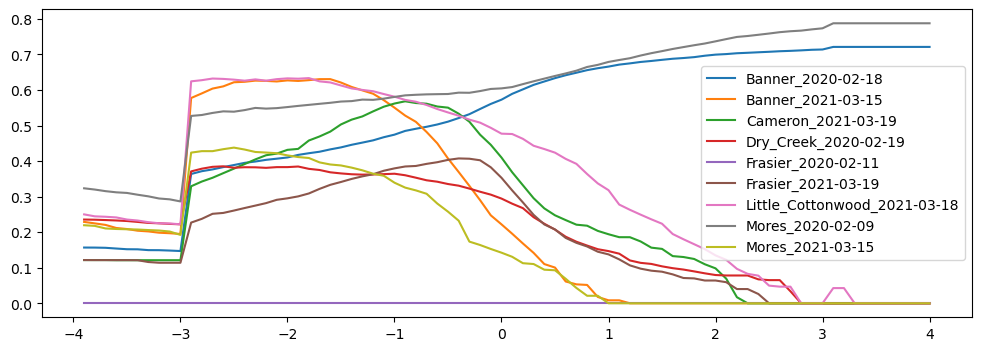

In [ ]:
f,ax=plt.subplots(figsize=(12,4))
thresh_results.plot(ax=ax)

In [ ]:
#thresh_results

In [ ]:
#r.values

In [ ]:
#r.wet_snow_thresh.values

In [ ]:
#wst_list

In [ ]:
# rmse_default = []
# ds_list = []

# res_default = pd.Series(rmse_default, index=ds_list)
# res_default

# results = sorted(glob('rmse_out/*.nc'))
# res_df = pd.DataFrame(res_default, columns=['rmse_default'])
# minn, a_list, b_list, c_list, wst_list= [], [], [], [], []
# for f in results:
#     if 'no_flag' in f:
#         continue
#     r = xr.open_dataarray(f).load()
#     ds_name = f.split('rmse_out/')[-1]
#     ds_name = ds_name.split('_wet')[0]
#     try:
#         rmse_min = r.min().values[0]
#     except IndexError:
#         rmse_min = float(r.min().values)
#     minn.append(rmse_min)
#     if r.min() > 0:
#         wst= [int(i) for i in np.where(r == r.min())]
#     else:
#         wst = 0

#     wst_list.append(float(r['wet_snow_thresh'][wst].values))

# res_df['rmse_opt'] = minn
# res_df['pct_change'] = (res_df['rmse_default'] - res_df['rmse_opt']) / res_df['rmse_default']
# #res_df.loc['Frasier_2020-02-11'] = np.nan
# res_df
    

In [ ]:
# f,ax=plt.subplots()
# rmse_wet_flag.plot(ax=ax)
# rmse_no_flag.plot(ax=ax)

In [99]:
# %%time
files = sorted(glob('spicy_s1_stacks/*.nc'))

# Create parameter space
A = np.arange(1, 3, 1)
B = np.arange(0.2, 1.2, 0.2)
C = np.arange(0.2, 1.1, 0.1)

#A = 2.5
#B = 0.2
#C = 0.55
#wet_snow_thresh = np.arange(-1, -4, -1)
wet_snow_thresh = np.arange(-4, 0.2, 0.2)

for f in files:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    #if 'Frasier_2021' not in ds_name:
    #    continue
    print(datetime.now(), f' -- starting {ds_name}')
    # Open dataset 
    ds_ = xr.open_dataset(f).load()
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]
    # Initialize RMSE arrays
    rmse_wet_flag = xr.DataArray(np.empty((len(A), len(B), len(C),len(wet_snow_thresh)))*np.nan,
                        coords=(A, B, C,wet_snow_thresh), dims=('A','B','C','wet_snow_thresh'))
    rmse_no_flag = xr.DataArray(np.empty((len(A), len(B), len(C), len(wet_snow_thresh)))*np.nan,
                        coords=(A, B, C, wet_snow_thresh), dims=('A','B','C','wet_snow_thresh'))
    valid_pixels = xr.DataArray(np.empty((len(A), len(B), len(C), len(wet_snow_thresh)))*np.nan,
                        coords=(A, B, C, wet_snow_thresh), dims=('A','B','C','wet_snow_thresh'))
    
    # Brute-force loop
    for a in A:
        for b in B:
            for c in C:
                for wst in wet_snow_thresh:
                    ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
                    ds = calc_delta_gamma(ds, B=b, inplace=False)
                    print(f'A={a:0.2f}; B={b:0.2f}; C={c:0.2f}; wst={wst:0.2f}')
                    ds = clip_delta_gamma_outlier(ds)
                    ds = calc_snow_index(ds)
                    ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
                    ds = id_newly_wet_snow(ds,wet_thresh=wst)
                    ds = id_wet_negative_si(ds)
                    ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
                    ds = flag_wet_snow(ds)
                    # Compare snow depths - mask wet snow
                    mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
                            ds['wet_snow'].sel(time=closest_ts).astype(bool))
                    diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
                    rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
                    print(f'RMSE wet = {rmse_wet:0.2f}')
                    rmse_wet_flag.loc[a, b, c,wst] = rmse_wet
                    # Compare snow depths - no wet snow mask
                    mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
                    diff = ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)
                    rmse = float(np.sqrt((diff**2).sum()/len(diff.values.flatten())))
                    print(f'RMSE = {rmse:0.2f}')
                    rmse_no_flag.loc[a,b,c,wst] = rmse
                    valid_pixels.loc[a,b,c,wst] = (mask.sum()-mask_wet.sum()) / mask.sum()
                    print(f'Frac valid pixels = {(mask.sum()-mask_wet.sum()) / mask.sum():0.2f}')
    # After loop, save RMSE results per file
    rmse_wet_flag.to_netcdf(f'rmse_out_full/{ds_name}_wet_flag.nc')
    rmse_no_flag.to_netcdf(f'rmse_out_full/{ds_name}_no_flag.nc')
    valid_pixels.to_netcdf(f'rmse_out_full/{ds_name}_valid_pixels.nc')
    break
    

2023-06-12 15:56:06.467868  -- starting Banner_2020-02-18
A=1.00; B=0.20; C=0.20; wst=-4.00
RMSE wet = 0.23
RMSE = 1.07
Frac valid pixels = 0.05
A=1.00; B=0.20; C=0.20; wst=-3.80
RMSE wet = 0.23
RMSE = 1.07
Frac valid pixels = 0.05
A=1.00; B=0.20; C=0.20; wst=-3.60
RMSE wet = 0.23
RMSE = 1.07
Frac valid pixels = 0.05
A=1.00; B=0.20; C=0.20; wst=-3.40
RMSE wet = 0.23
RMSE = 1.07
Frac valid pixels = 0.05
A=1.00; B=0.20; C=0.20; wst=-3.20
RMSE wet = 0.23
RMSE = 1.07
Frac valid pixels = 0.05
A=1.00; B=0.20; C=0.20; wst=-3.00
RMSE wet = 0.24
RMSE = 1.07
Frac valid pixels = 0.05
A=1.00; B=0.20; C=0.20; wst=-2.80
RMSE wet = 0.25
RMSE = 1.07
Frac valid pixels = 0.05
A=1.00; B=0.20; C=0.20; wst=-2.60
RMSE wet = 0.26
RMSE = 1.07
Frac valid pixels = 0.06
A=1.00; B=0.20; C=0.20; wst=-2.40
RMSE wet = 0.27
RMSE = 1.07
Frac valid pixels = 0.06
A=1.00; B=0.20; C=0.20; wst=-2.20
RMSE wet = 0.29
RMSE = 1.07
Frac valid pixels = 0.07
A=1.00; B=0.20; C=0.20; wst=-2.00
RMSE wet = 0.31
RMSE = 1.07
Frac valid

In [100]:
results1 = sorted(glob('rmse_out_full/*wet*.nc'))
results2 = sorted(glob('rmse_out_full/*no*.nc'))
results3 = sorted(glob('rmse_out_full/*valid*.nc'))

In [101]:
wet_snow = xr.open_dataarray(results1[0])
all_snow = xr.open_dataarray(results2[0])
frac_valid = xr.open_dataarray(results3[0])


In [128]:
all_rmse = xr.concat([wet_snow,all_snow],'wet_or_all')

TypeError: DataArray.rename() takes from 1 to 2 positional arguments but 3 were given

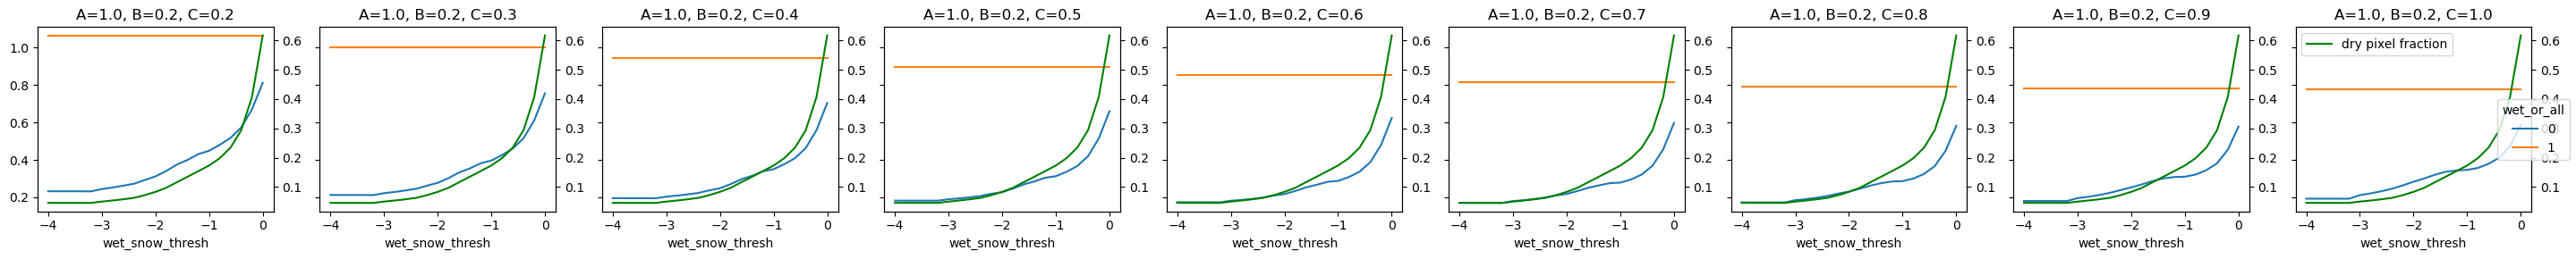

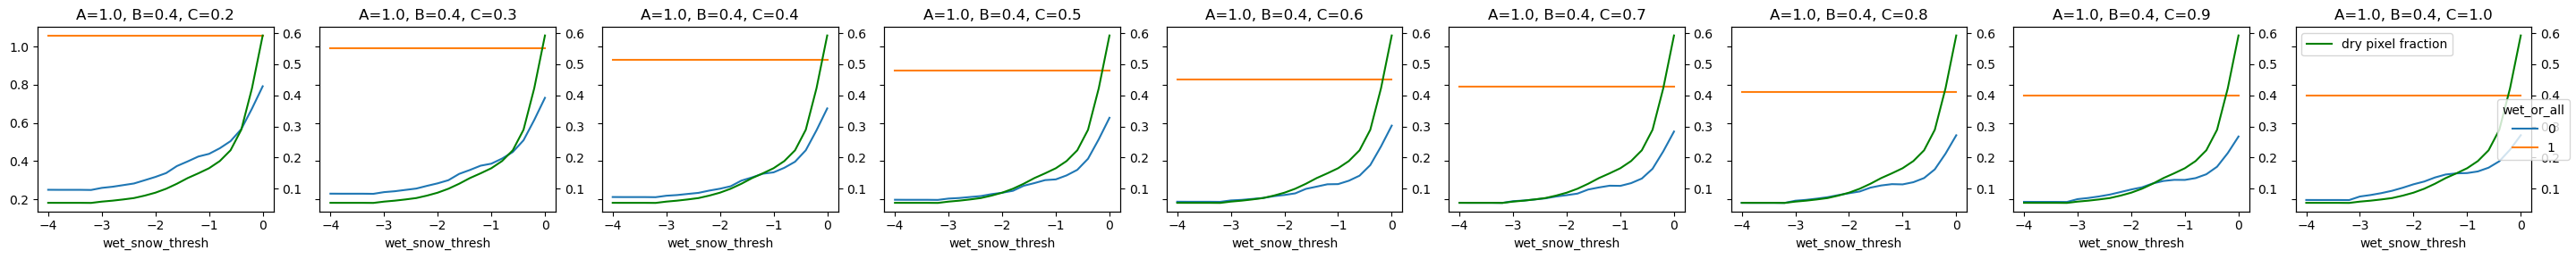

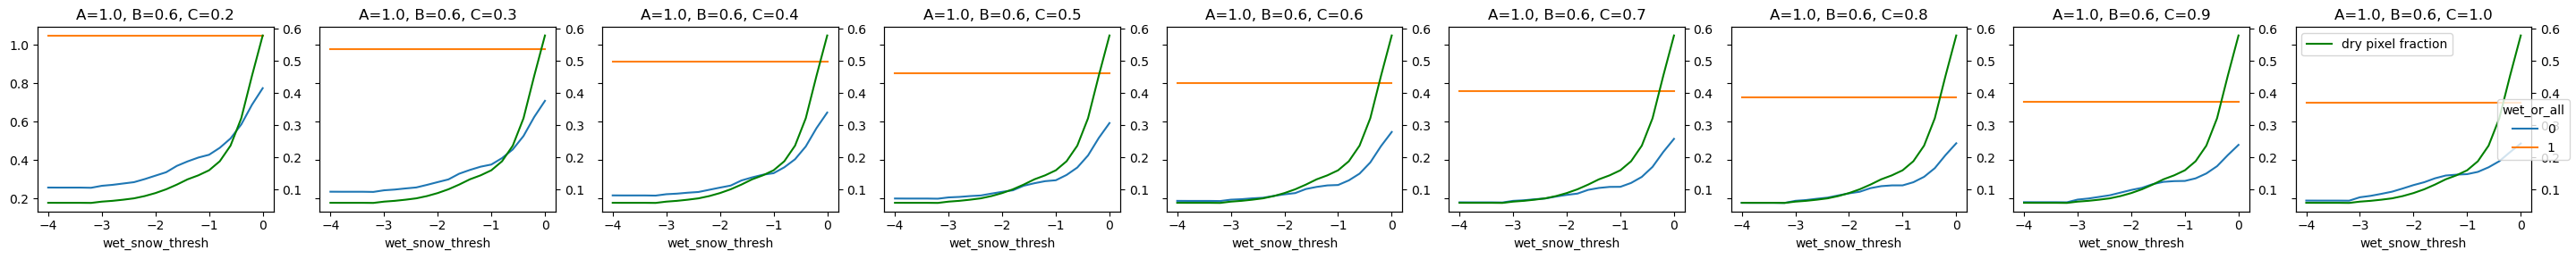

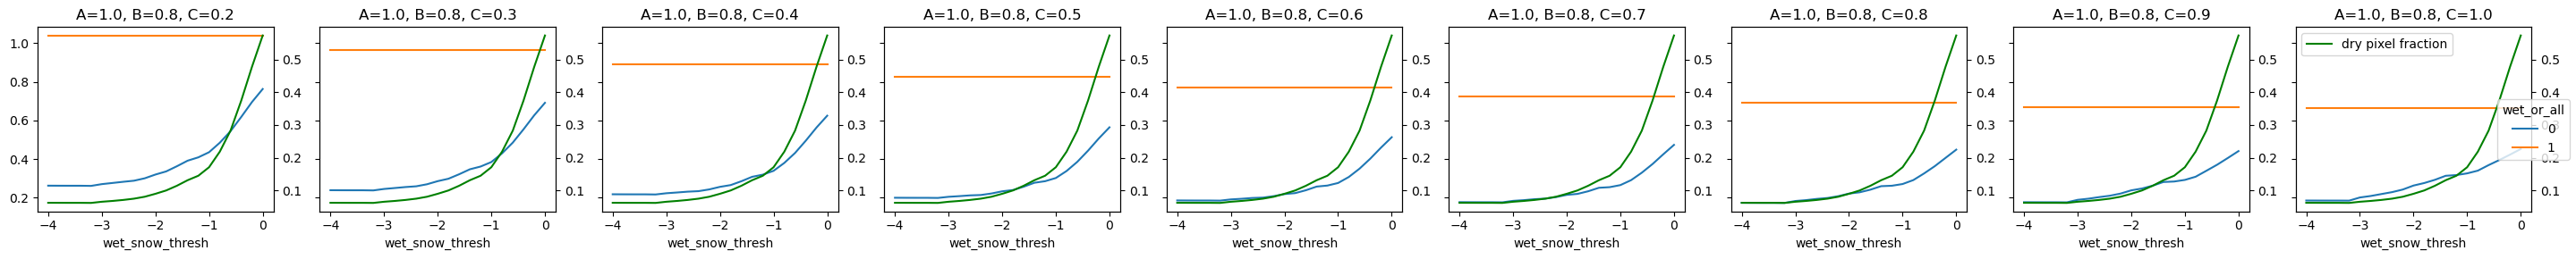

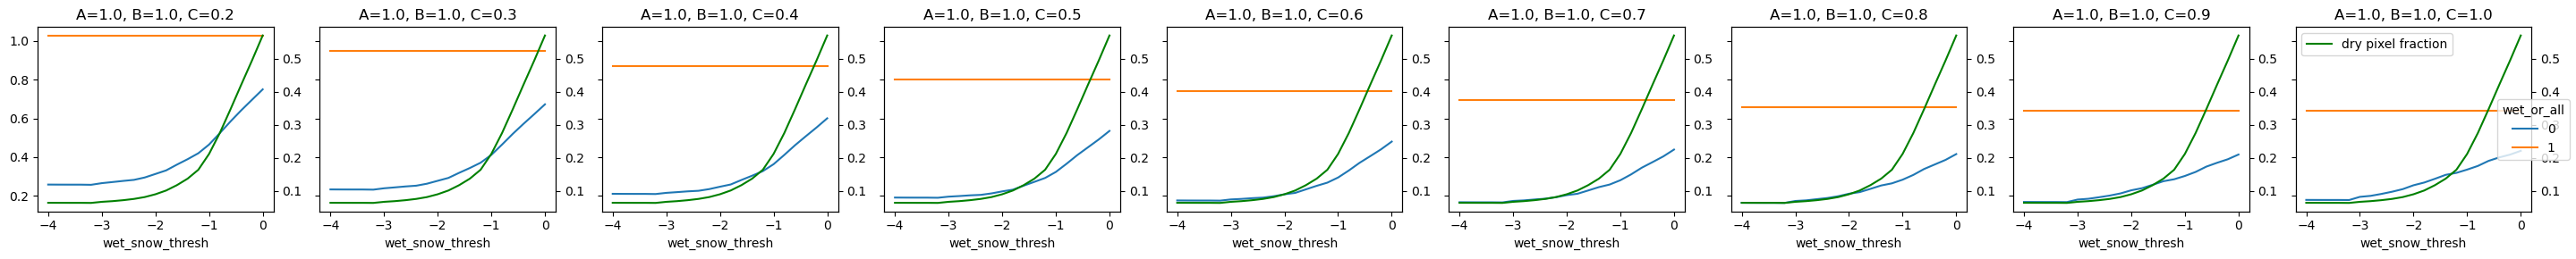

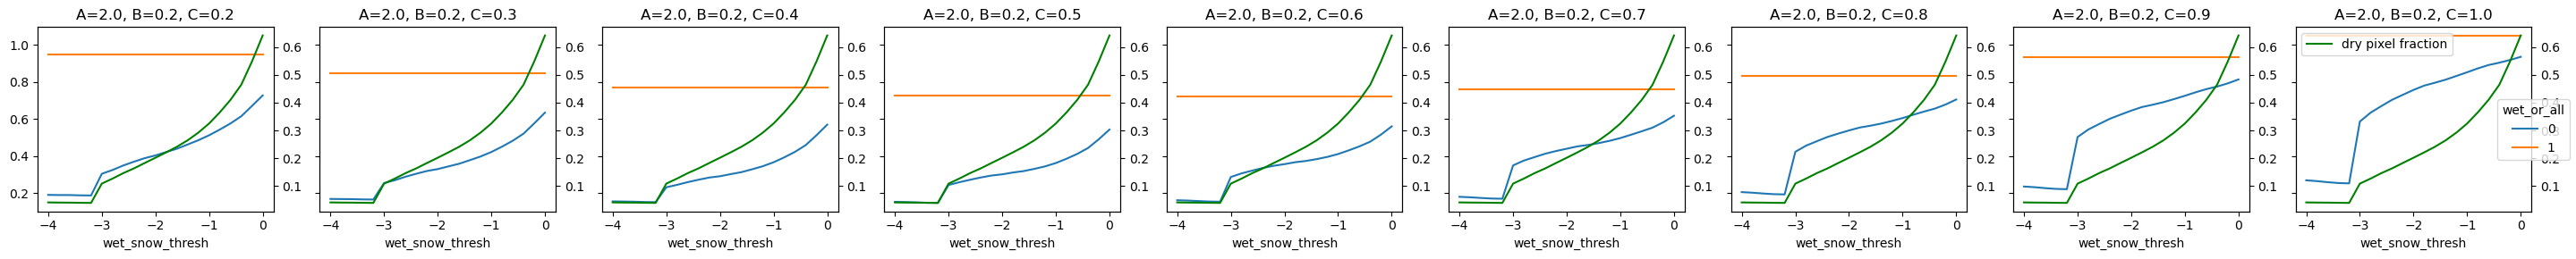

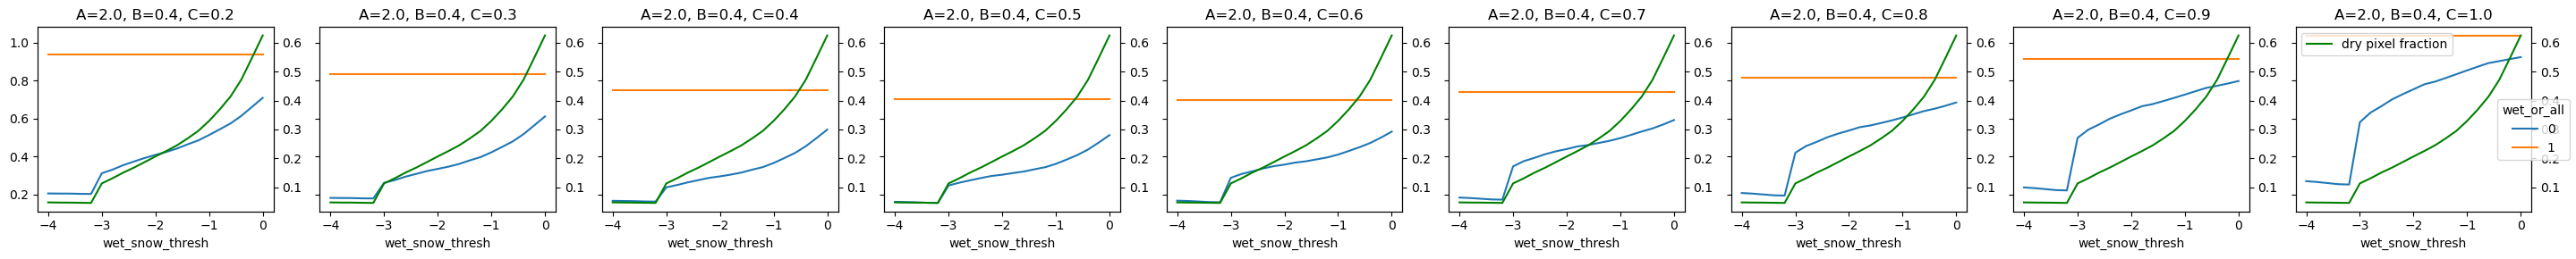

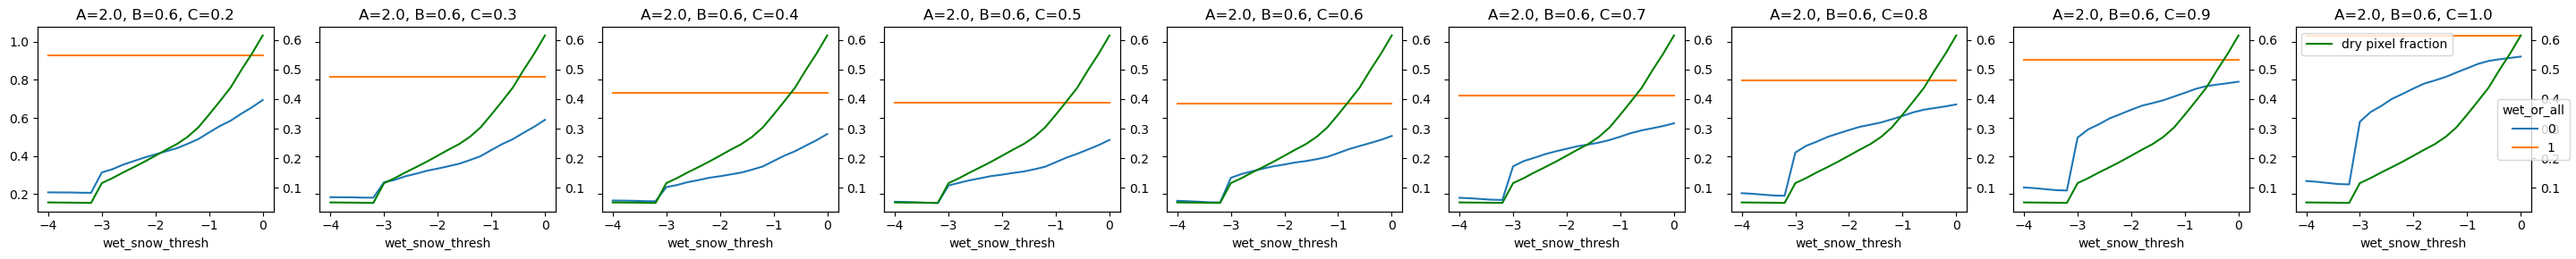

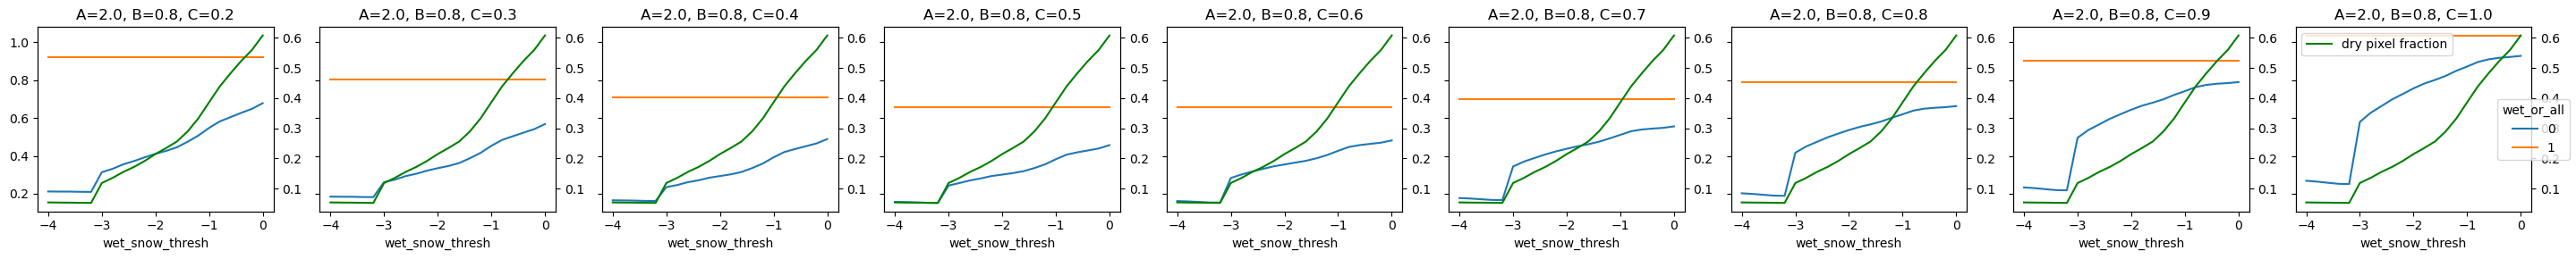

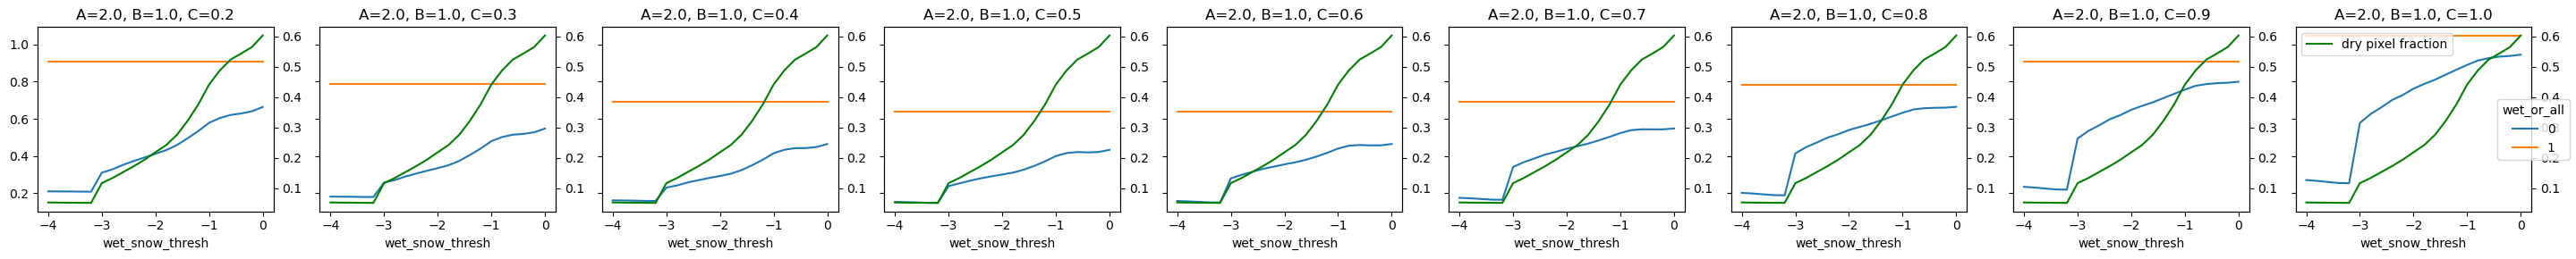

In [129]:
for a in A:
    for b in B:
        f = all_rmse.sel(A=a).sel(B=b).plot(hue='wet_or_all',col='C')
        for c,ax in zip(C,f.axs[0]):
            frac_ax = ax.twinx()
            frac_valid.sel(A=a).sel(B=b).sel(C=c).plot(ax=frac_ax,color='green',label='dry pixel fraction')
            frac_ax.set_title('')
            #print(wet_snow.sel(A=a).sel(B=b).sel(C=c).idxmin())
            ax.set_title(f'A={a:0.1f}, B={b:0.1f}, C={c:0.1f}')
        frac_ax.legend()
        plt.tight_layout()

In [145]:
a = 2.5
b = 0.2
c = 0.55
wst = -2

ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
ds = calc_delta_gamma(ds, B=b, inplace=False)
print(f'A={a:0.2f}; B={b:0.2f}; C={c:0.2f}; wst={wst:0.2f}')
ds = clip_delta_gamma_outlier(ds)
ds = calc_snow_index(ds)
ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
ds = id_newly_wet_snow(ds,wet_thresh=wst)
ds = id_wet_negative_si(ds)
ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
ds = flag_wet_snow(ds)

ds

A=2.50; B=0.20; C=0.55; wst=-2.00


<xarray.Dataset>
Dimensions:         (x: 185, y: 144, band: 3, time: 58)
Coordinates:
  * x               (x) float64 -115.3 -115.3 -115.3 ... -115.1 -115.1 -115.1
  * y               (y) float64 44.34 44.34 44.34 44.34 ... 44.2 44.19 44.19
  * band            (band) object 'VV' 'VH' 'inc'
  * time            (time) datetime64[ns] 2019-08-05T01:35:54 ... 2020-03-02T...
    flight_dir      (time) object 'ascending' 'ascending' ... 'ascending'
    platform        (time) object 'S1B' 'S1B' 'S1B' 'S1B' ... 'S1B' 'S1B' 'S1A'
    relative_orbit  (time) float64 93.0 20.0 93.0 20.0 ... 20.0 71.0 93.0 93.0
    projection      int64 0
Data variables: (12/14)
    s1              (time, band, y, x) float32 -10.13 -8.989 ... 0.4616 0.4043
    deltaVV         (time, y, x) float32 nan nan nan ... -0.7037 0.8927 1.024
    ims             (time, y, x) float64 2.0 2.0 2.0 2.0 2.0 ... 4.0 4.0 4.0 4.0
    fcf             (y, x) float64 0.38 0.38 0.69 0.9 0.73 ... 0.12 0.13 0.0 0.0
    lidar-sd        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    deltaCR         (time, y, x) float32 nan nan nan nan ... 2.601 1.41 -1.994
    ...              ...
    snow_depth      (y, x, time) float64 0.0 0.0 0.0 ... 0.07265 2.288 0.2073
    wet_flag        (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    alt_wet_flag    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    freeze_flag     (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 1.0 0.0 0.0
    wet_snow        (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 1.0
    perma_wet       (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.5 0.25 0.25 0.25
Attributes:
    AREA_OR_POINT:      Point
    TIFFTAG_DATETIME:   2023:02:25 03:57:04
    TIFFTAG_SOFTWARE:   Created with GAMMA Software www.gamma-rs.ch data2geot...
    scale_factor:       1.0
    add_offset:         0.0
    resolution:         90
    s1_units:           dB
    site:               Banner
    site_abbrev:        USIDBS
    lidar-flight-time:  2020-02-18

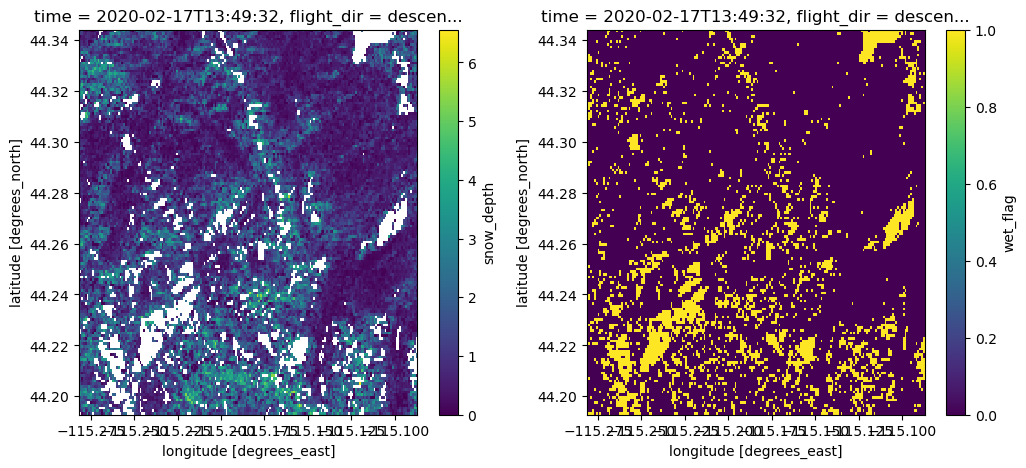

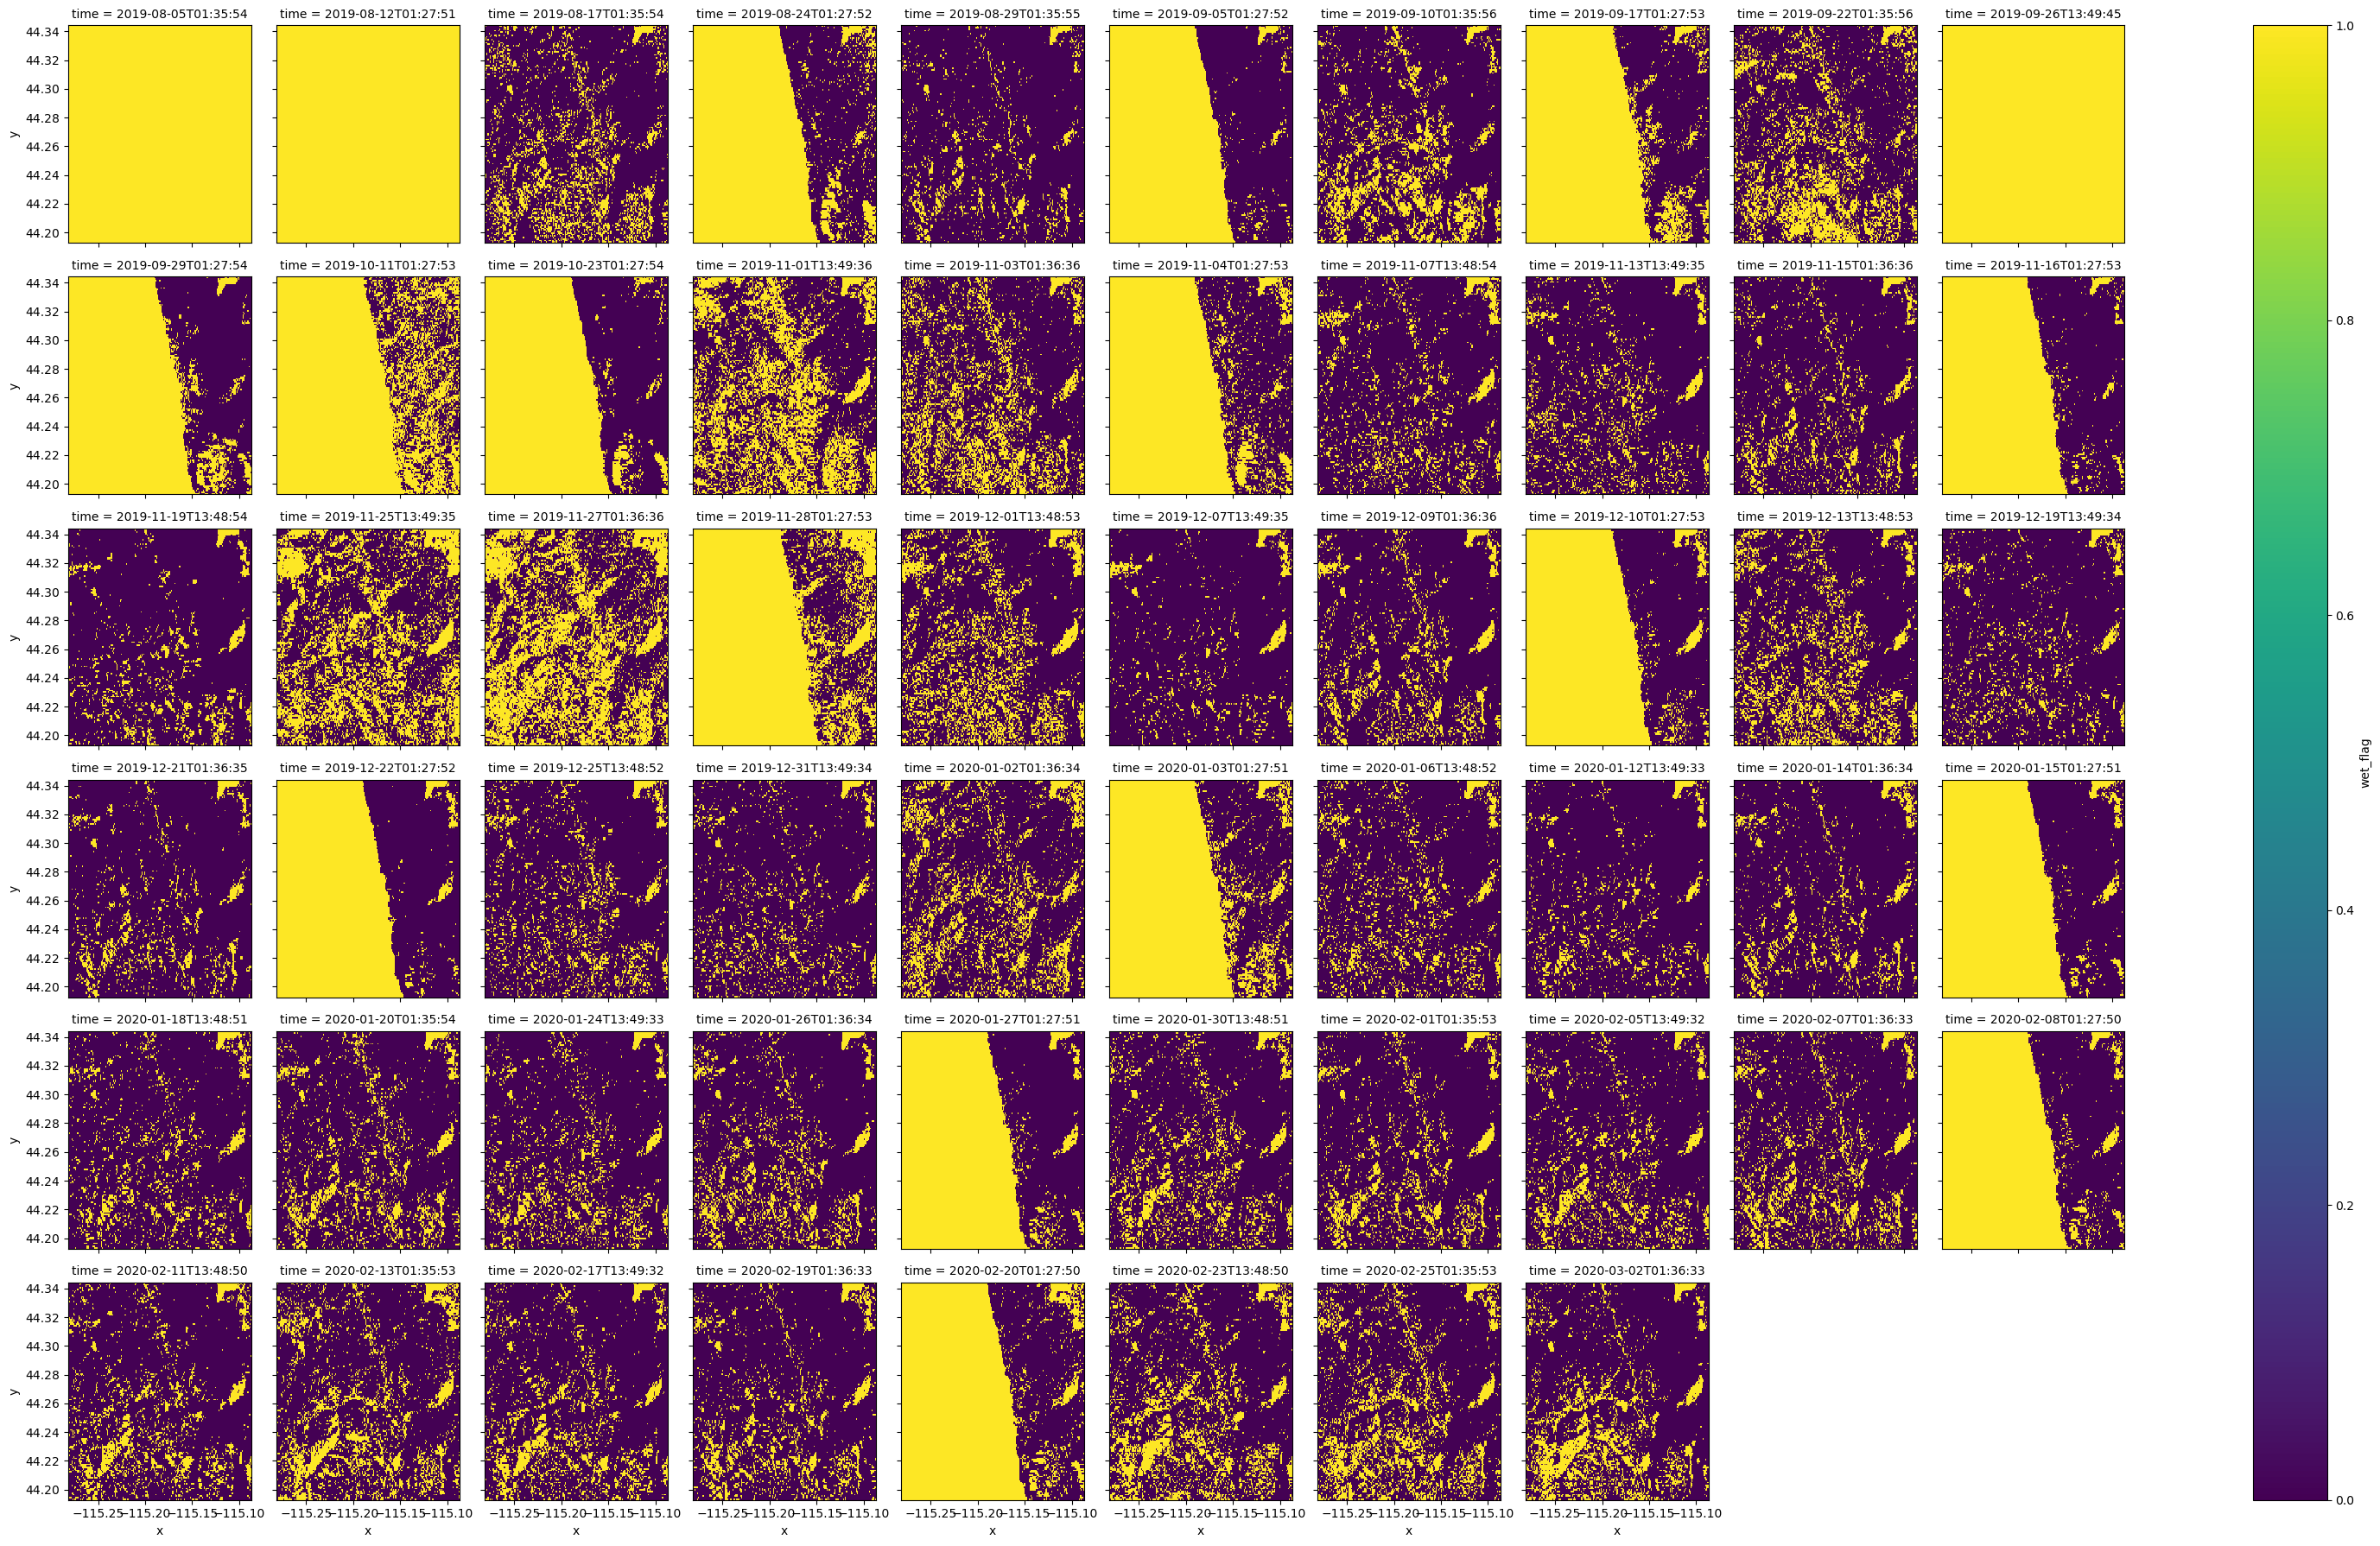

In [144]:
f,ax=plt.subplots(1,2,figsize=(12,5))
ds['snow_depth'].sel(time=closest_ts).plot(ax=ax[0])
ds['wet_flag'].sel(time=closest_ts).plot(ax=ax[1])

ds['wet_flag'].plot(col='time',col_wrap=10)

In [146]:
a = 2.5
b = 0.2
c = 0.55
wst = -3

ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
ds = calc_delta_gamma(ds, B=b, inplace=False)
print(f'A={a:0.2f}; B={b:0.2f}; C={c:0.2f}; wst={wst:0.2f}')
ds = clip_delta_gamma_outlier(ds)
ds = calc_snow_index(ds)
ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
ds = id_newly_wet_snow(ds,wet_thresh=wst)
ds = id_wet_negative_si(ds)
ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
ds = flag_wet_snow(ds)

ds

A=2.50; B=0.20; C=0.55; wst=-3.00


<xarray.Dataset>
Dimensions:         (x: 185, y: 144, band: 3, time: 58)
Coordinates:
  * x               (x) float64 -115.3 -115.3 -115.3 ... -115.1 -115.1 -115.1
  * y               (y) float64 44.34 44.34 44.34 44.34 ... 44.2 44.19 44.19
  * band            (band) object 'VV' 'VH' 'inc'
  * time            (time) datetime64[ns] 2019-08-05T01:35:54 ... 2020-03-02T...
    flight_dir      (time) object 'ascending' 'ascending' ... 'ascending'
    platform        (time) object 'S1B' 'S1B' 'S1B' 'S1B' ... 'S1B' 'S1B' 'S1A'
    relative_orbit  (time) float64 93.0 20.0 93.0 20.0 ... 20.0 71.0 93.0 93.0
    projection      int64 0
Data variables: (12/14)
    s1              (time, band, y, x) float32 -10.13 -8.989 ... 0.4616 0.4043
    deltaVV         (time, y, x) float32 nan nan nan ... -0.7037 0.8927 1.024
    ims             (time, y, x) float64 2.0 2.0 2.0 2.0 2.0 ... 4.0 4.0 4.0 4.0
    fcf             (y, x) float64 0.38 0.38 0.69 0.9 0.73 ... 0.12 0.13 0.0 0.0
    lidar-sd        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    deltaCR         (time, y, x) float32 nan nan nan nan ... 2.601 1.41 -1.994
    ...              ...
    snow_depth      (y, x, time) float64 0.0 0.0 0.0 ... 0.07265 2.288 0.2073
    wet_flag        (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    alt_wet_flag    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    freeze_flag     (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    wet_snow        (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    perma_wet       (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.5 0.25 0.25 0.0
Attributes:
    AREA_OR_POINT:      Point
    TIFFTAG_DATETIME:   2023:02:25 03:57:04
    TIFFTAG_SOFTWARE:   Created with GAMMA Software www.gamma-rs.ch data2geot...
    scale_factor:       1.0
    add_offset:         0.0
    resolution:         90
    s1_units:           dB
    site:               Banner
    site_abbrev:        USIDBS
    lidar-flight-time:  2020-02-18

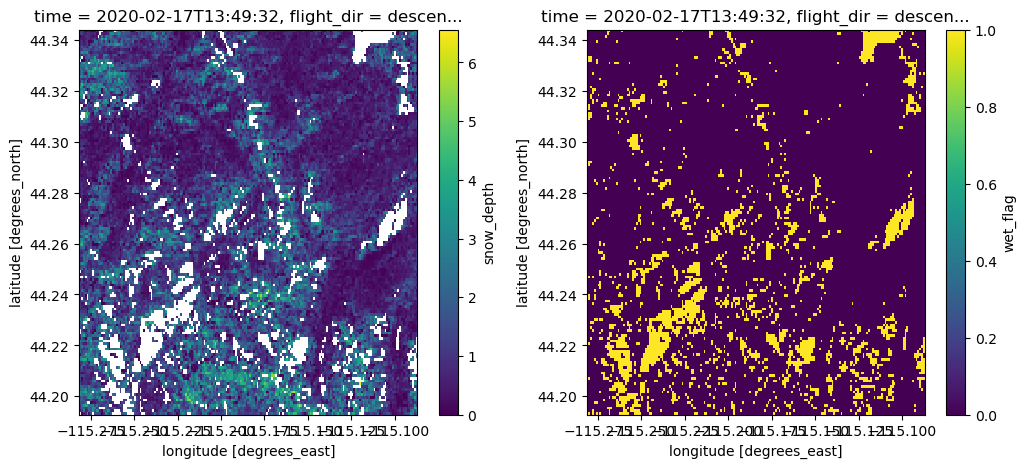

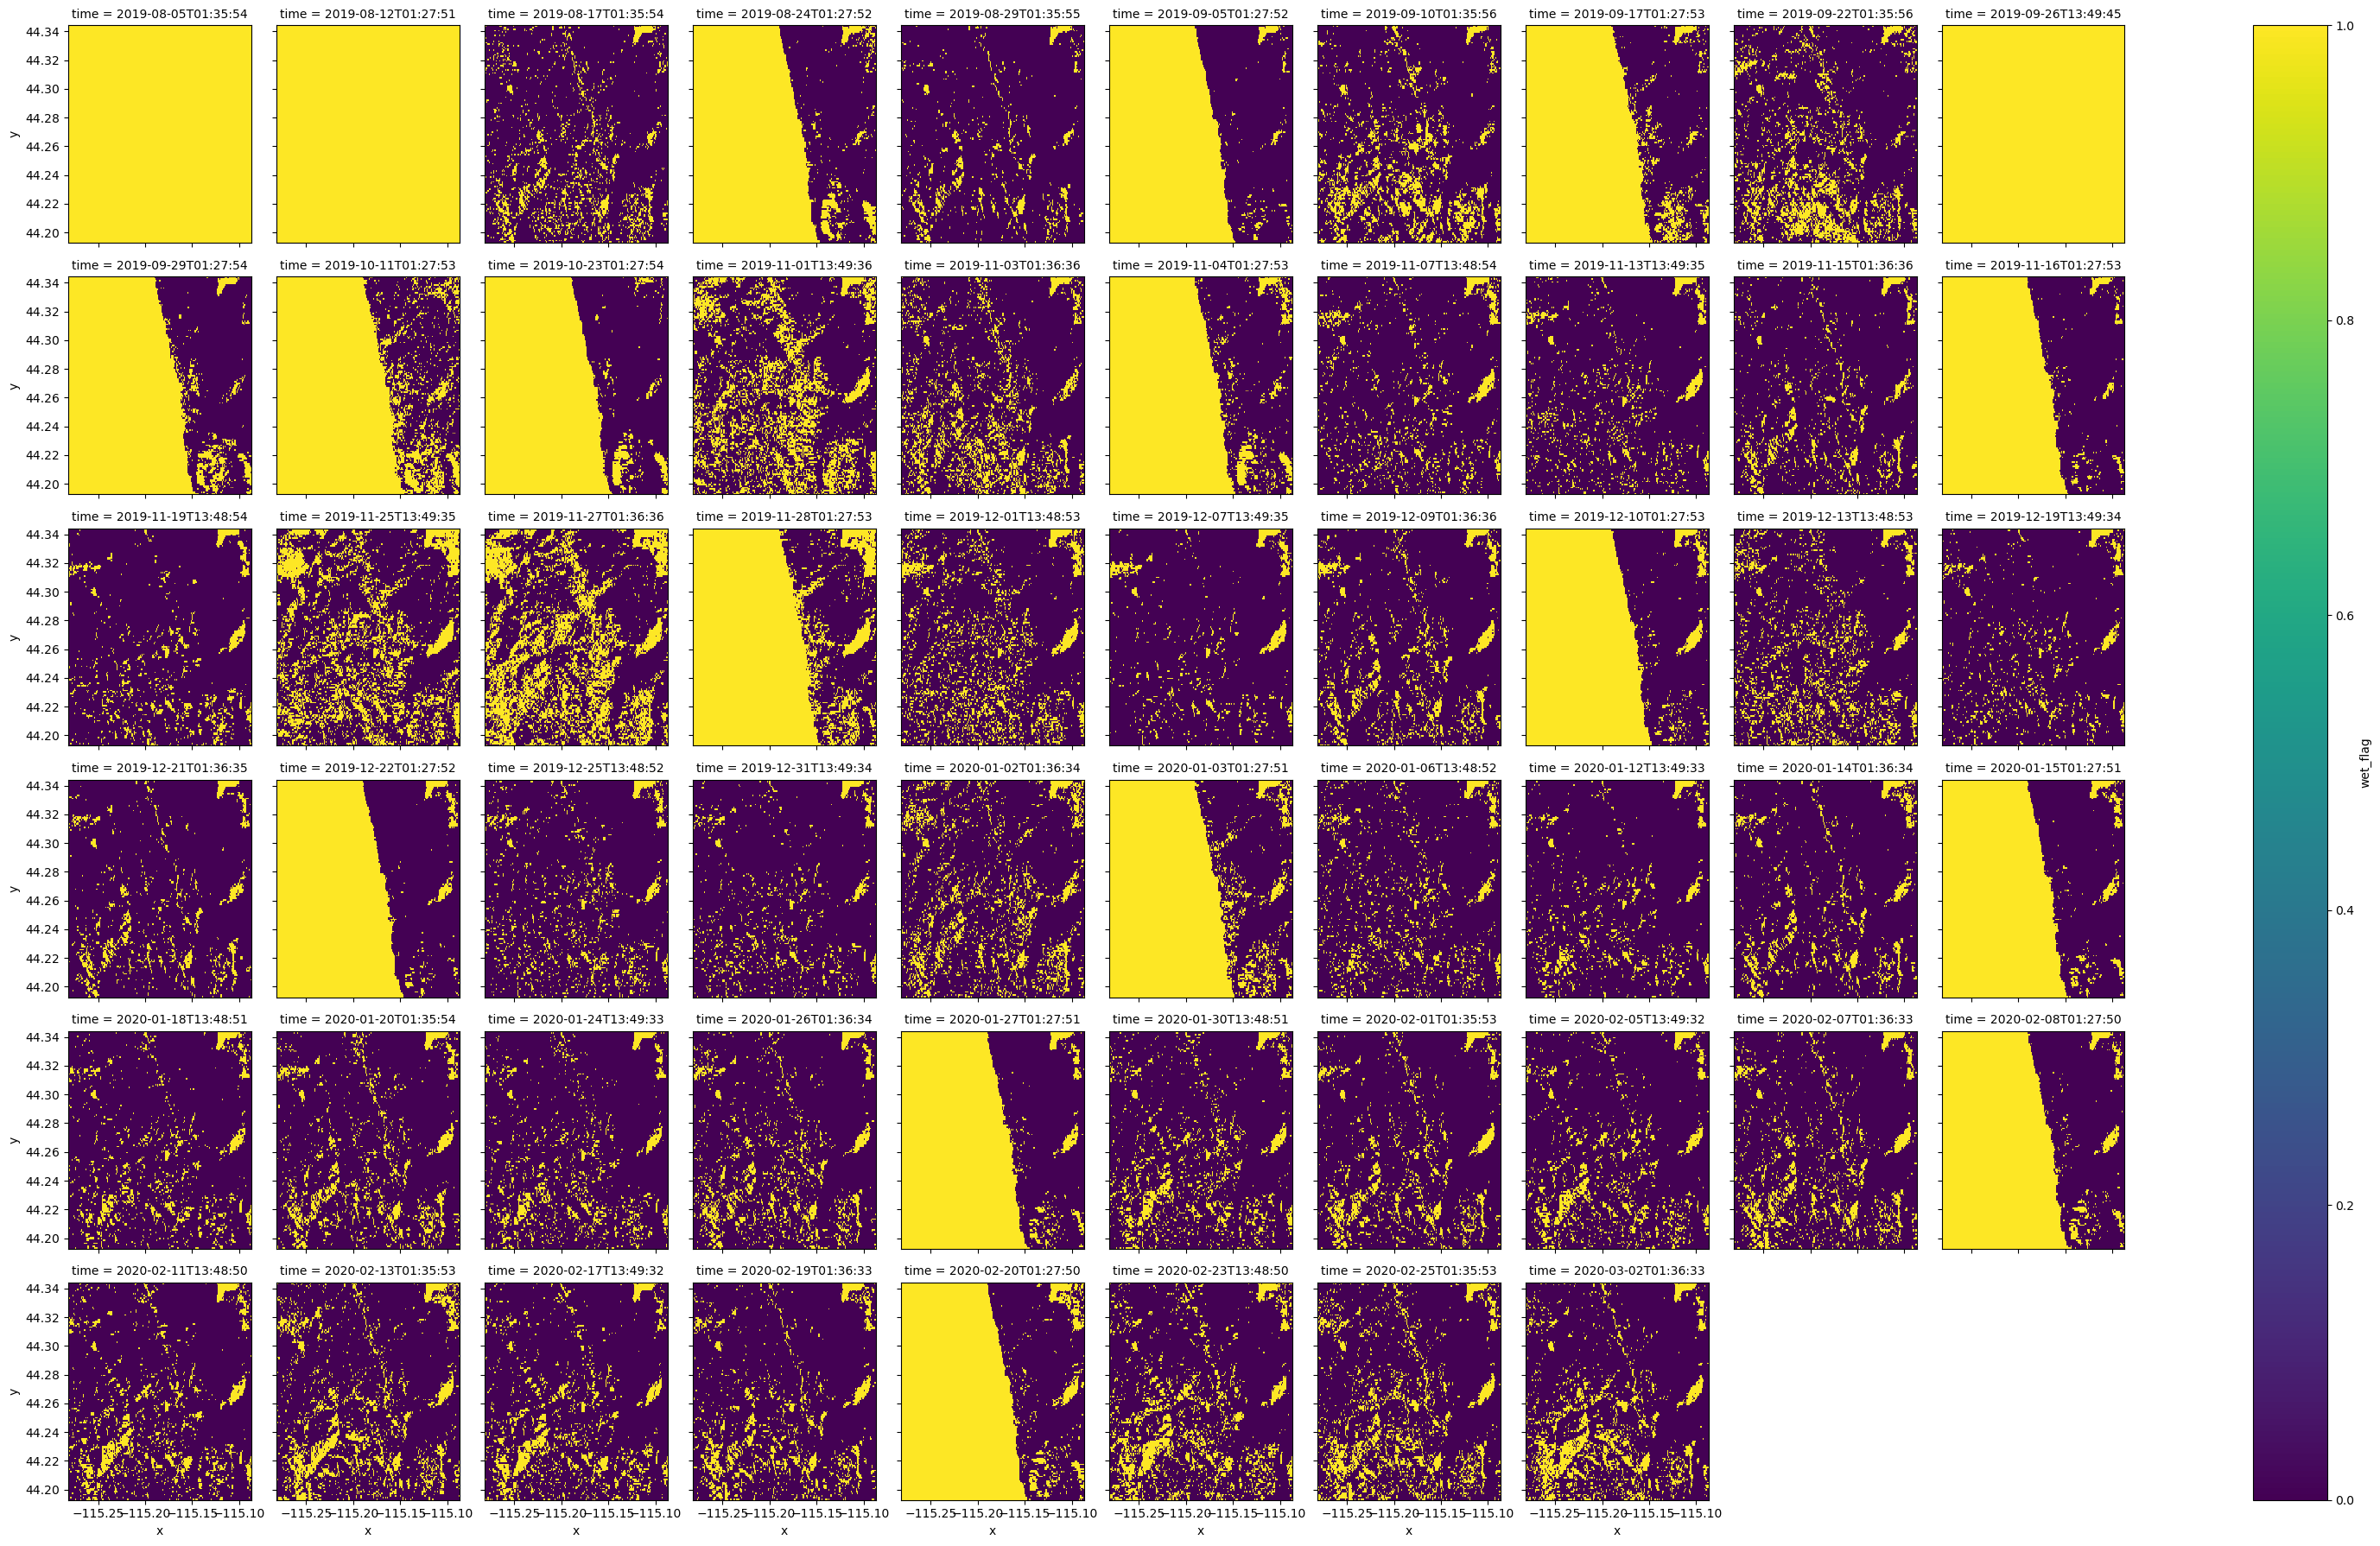

In [147]:
f,ax=plt.subplots(1,2,figsize=(12,5))
ds['snow_depth'].sel(time=closest_ts).plot(ax=ax[0])
ds['wet_flag'].sel(time=closest_ts).plot(ax=ax[1])

ds['wet_flag'].plot(col='time',col_wrap=10)

A=2.50; B=0.20; C=0.55; wst=0.00
A=2.50; B=0.20; C=0.55; wst=-1.00
A=2.50; B=0.20; C=0.55; wst=-2.00
A=2.50; B=0.20; C=0.55; wst=-3.00
A=2.50; B=0.20; C=0.55; wst=-4.00


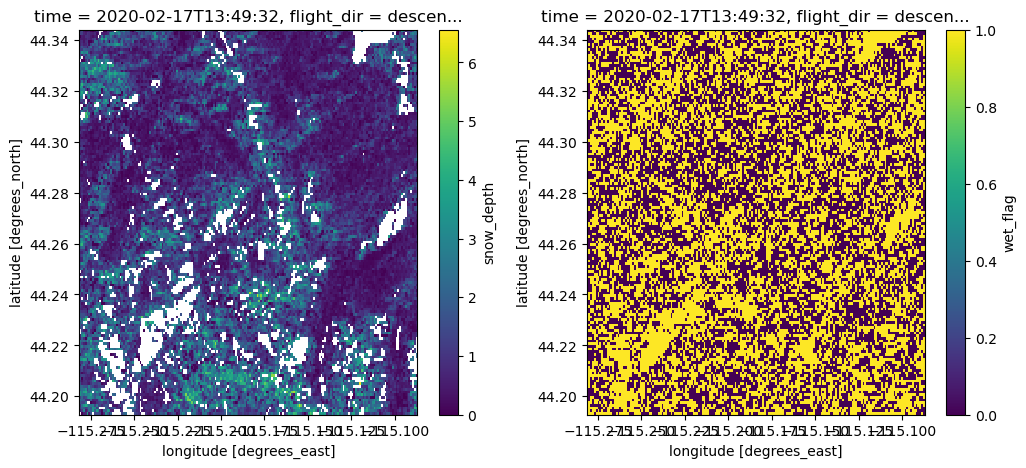

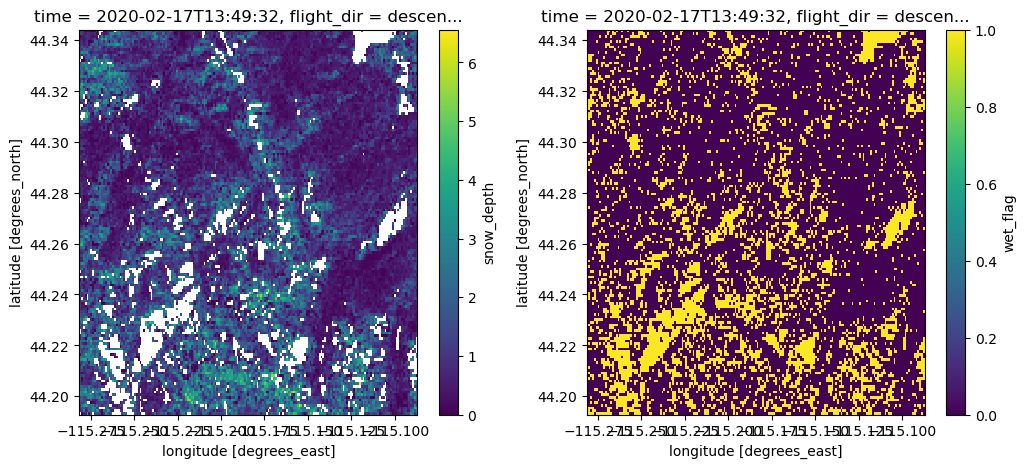

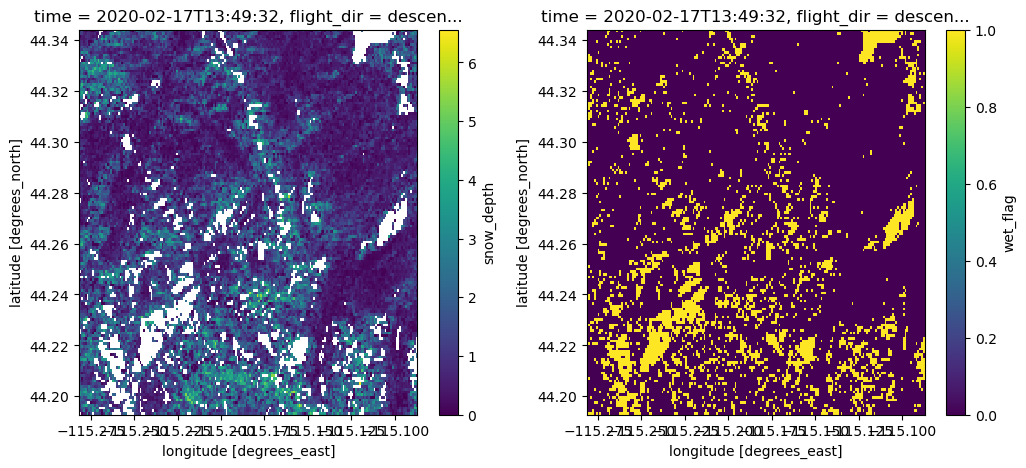

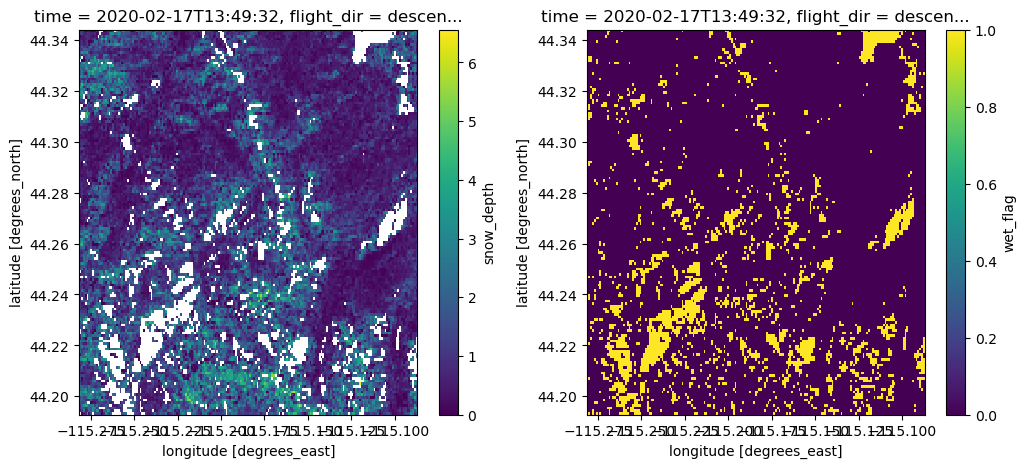

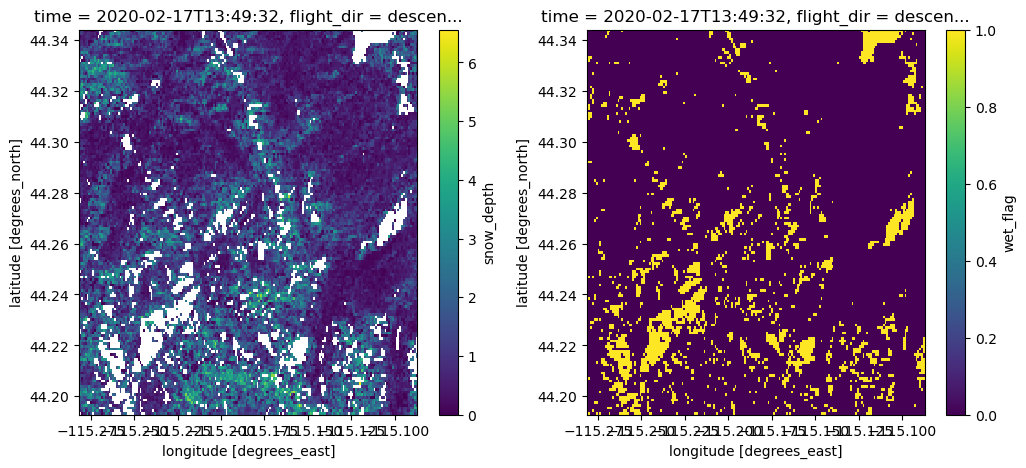

In [151]:
a = 2.5
b = 0.2
c = 0.55

for wst in [0,-1,-2,-3,-4]:
    ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
    ds = calc_delta_gamma(ds, B=b, inplace=False)
    print(f'A={a:0.2f}; B={b:0.2f}; C={c:0.2f}; wst={wst:0.2f}')
    ds = clip_delta_gamma_outlier(ds)
    ds = calc_snow_index(ds)
    ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
    ds = id_newly_wet_snow(ds,wet_thresh=wst)
    ds = id_wet_negative_si(ds)
    ds = id_newly_frozen_snow(ds,freeze_thresh=-1*wst)
    ds = flag_wet_snow(ds)
    f,ax=plt.subplots(1,2,figsize=(12,5))
    ds['snow_depth'].sel(time=closest_ts).plot(ax=ax[0])
    ds['wet_flag'].sel(time=closest_ts).plot(ax=ax[1])


In [162]:
#mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | ds['wet_snow'].sel(time=closest_ts).astype(bool))
#mask_wet.sum()
# f,ax=plt.subplots()
# ax.imshow(mask_wet)
# mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
# mask
# f,ax=plt.subplots()
# ax.imshow(mask)